## Planteamiento del problema

La primera pregunta que queremos responder es
**¿El número de datos limpios inicial $n$ afecta al rendimiento?**

En este experimento, consideraremos el siguiente escenario:
- Tenemos $n$ imágenes con etiquetas limpias.
- Por cada imagen con etiquetas limpias, introducimos $\alpha$ imágenes con etiquetas ruidosas (es decir, su etiqueta es aleatoria). Por tanto, añadimos $\alpha n$ imágenes.
- En total, acabamos con $\alpha n + n = (\alpha+1)n $ imágenes

Las arquitecturas y *dataset* que utilizaremos en este experimento serán:
- Trabajaremos con el conjunto de datos MNIST.
- Trabarejemos con varios modelos con distinto orden de complejidad: MLP con 2 capas ocultas, redes neuronales con 4 y 6 capas convolucionales, respectivamente y ResNet18.
- Utilizaremos ruido uniforme, en el que la etiqueta ruidosa se asigna aleatoriamente entre las clases posibles, todas con la misma probabilidad.

Realizaremos el entrenamiento con el conjunto de datos ruidoso y evaluaremos su rendimiento en un conjunto de test limpio (sin ruido).

## Instalación de fastai

In [ ]:
!pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
from fastai.vision.all import *
import fastai
import numpy

print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
print("FastAI:", fastai.__version__)
print("NumPy:", numpy.__version__)

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch: 2.6.0+cu124
CUDA disponible: True
FastAI: 2.8.2
NumPy: 2.0.2


## Carga del *dataset* MNIST

Descargamos el *dataset* MNIST:

In [ ]:
# We get the MNIST dataset
path = untar_data(URLs.MNIST,force_download=True)

In [ ]:
# The MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the test set.
print(path)
print(path.ls())
print((path/'training').ls())
print((path/'testing').ls())
train_classes = (path/'training').ls()
test_classes = (path/'testing').ls()

/root/.fastai/data/mnist_png
[Path('/root/.fastai/data/mnist_png/testing'), Path('/root/.fastai/data/mnist_png/training')]
[Path('/root/.fastai/data/mnist_png/training/4'), Path('/root/.fastai/data/mnist_png/training/1'), Path('/root/.fastai/data/mnist_png/training/9'), Path('/root/.fastai/data/mnist_png/training/6'), Path('/root/.fastai/data/mnist_png/training/3'), Path('/root/.fastai/data/mnist_png/training/5'), Path('/root/.fastai/data/mnist_png/training/8'), Path('/root/.fastai/data/mnist_png/training/7'), Path('/root/.fastai/data/mnist_png/training/0'), Path('/root/.fastai/data/mnist_png/training/2')]
[Path('/root/.fastai/data/mnist_png/testing/4'), Path('/root/.fastai/data/mnist_png/testing/1'), Path('/root/.fastai/data/mnist_png/testing/9'), Path('/root/.fastai/data/mnist_png/testing/6'), Path('/root/.fastai/data/mnist_png/testing/3'), Path('/root/.fastai/data/mnist_png/testing/5'), Path('/root/.fastai/data/mnist_png/testing/8'), Path('/root/.fastai/data/mnist_png/testing/7'), P

Comprobamos que efectivamente disponemos de $60000$ ejemplos de entrenamiento y $10000$ de *test*, que el tamaño de las imágenes es $28\times 28$ y que el número de clases es $10$ ($0$-$9$).

In [ ]:
from cv2 import imread

n_training = np.sum([len(class_files.ls()) for class_files in train_classes])
n_test = np.sum([len(class_files.ls()) for class_files in test_classes])

img = imread(path/'training'/'0'/'1.png')
width, height = img.shape[0:2]
num_channels = 1
num_classes = len(train_classes)

print(f"Número de imágenes de entrenamiento: {n_training}")
print(f"Número de imágenes de test: {n_test}")
print(f"Tamaño de las imágenes: {width}x{height}")
print(f"Número de clases: {num_classes}")

Número de imágenes de entrenamiento: 60000
Número de imágenes de test: 10000
Tamaño de las imágenes: 28x28
Número de clases: 10


Seleccionamos un valor para $\alpha$, un valor para $n$ y fijamos la semilla aleatoria con el fin de garantizar la reproducibilidad en la mayor medida posible.

In [ ]:
alpha = 0
n = 10000
random.seed(42)

Creamos una función para seleccionar repetir las imágenes tantas veces como indique $\alpha$:

In [ ]:
def repeat_images(images, alpha):
    """Devuelve una lista con cada imagen repetida alpha veces."""
    return L(img for img in images for _ in range(alpha+1))

Creamos una función que selecciona un cierto número de imágenes (con clases balanceadas) del conjunto de entrenamiento:

In [ ]:
from fastcore.foundation import L

def get_balanced_images(path):
    """Selecciona hasta max_per_class imágenes por cada categoría."""
    all_images = get_image_files(path)
    by_class = {c: [] for c in set(parent_label(f) for f in all_images)}

    max_per_class = n / num_classes

    for img in all_images:
        label = parent_label(img)
        if len(by_class[label]) < max_per_class:
            by_class[label].append(img)

    selected_images = L([img for imgs in by_class.values() for img in imgs])
    return repeat_images(selected_images, alpha)

Seleccionamos las imágenes:

In [ ]:
selected_images = get_balanced_images(path/'training')

In [ ]:
len(selected_images)

10000

Creamos una función que selecciona las imágenes del conjunto de entrenamiento, y les asigna una etiqueta de forma aleatoria (uniforme):

In [ ]:
def get_labels(images):
  i = 0
  labels = []

  while(i<len(images)):
    labels.append(parent_label(images[i]))

    for j in range(alpha):
      labels.append(str(random.randint(0, 9)))

    i += 1+alpha

  return labels

In [ ]:
labels = get_labels(selected_images)

Combinamos todo en un *datablock* (que es la forma que tiene fastai de gestionar los datos de entrada):

In [ ]:
batch_size = 128
valid_part = 0.2

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=lambda _: range(0,len(selected_images)),
    get_x=lambda x: selected_images[x],
    get_y=lambda x: labels[x],
    splitter=RandomSplitter(valid_pct=valid_part, seed=42)
)

dls = dblock.dataloaders(path/'training', bs=batch_size)

Mostramos algunos ejemplos de nuestros datos de entrada:

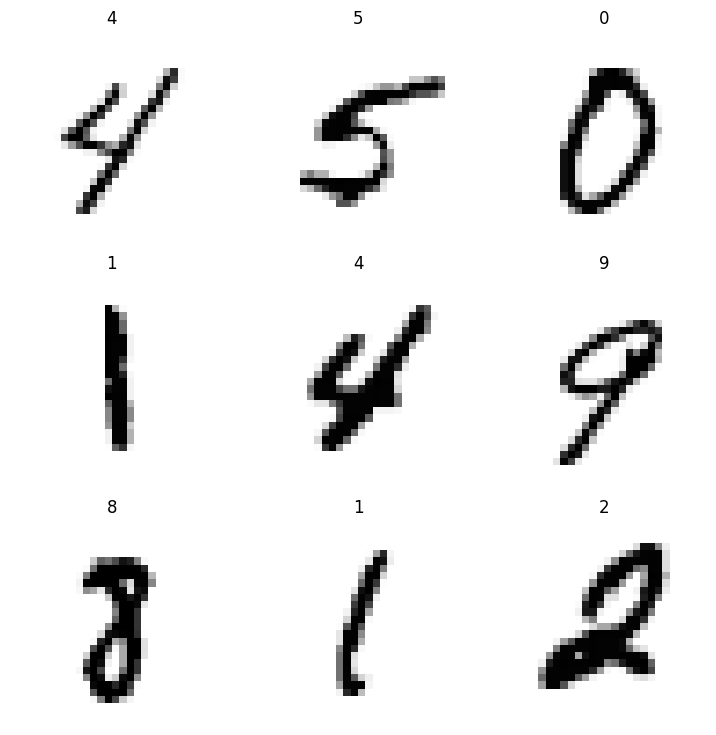

In [ ]:
dls.show_batch(max_n=9)

## Arquitecturas de redes neuronales

Creamos y entrenamos los distintos modelos.

Seleccionamos distintos hiperparámetros:

In [ ]:
early_stopping_patience = 3
num_epochs = 4

### MLP-2

Seleccionamos el *learning rate*:

In [ ]:
learning_rate = 0.1

En primer lugar, consideramos un MLP con $2$ capas ocultas.

#### Creación del modelo

In [ ]:
from torch.nn import Linear, ReLU, Flatten, BatchNorm1d
from torch.optim import Adadelta
from torchsummary import summary

# Crear el MLP con 2 capas ocultas
opt_func = partial(OptimWrapper, opt=Adadelta, lr=learning_rate)

mlp2 = sequential(
    Flatten(),                              # Aplana la imagen de 28x28 a un vector de 784
    Linear(width*height*num_channels, 512), # Capa densa con tantas entradas como píxeles tenga la imagen y 512 salidas
    ReLU(),                                 # Función de activación ReLU
    BatchNorm1d(512),                       # Capa de Batch Normalization
    Linear(512, 512),                       # Capa densa con 512 entradas y 512 salidas
    ReLU(),                                 # Función de activación ReLU
    BatchNorm1d(512),                       # Capa de Batch Normalization
    Linear(512, num_classes)                # Capa de salida con num_classes salidas
)

# Crear el aprendiz (learner)
learn = Learner(
    dls,
    mlp2,
    metrics=[
        accuracy,
        F1Score(average='weighted')
    ],
    opt_func=opt_func,
    loss_func=CrossEntropyLossFlat(),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=early_stopping_patience)]
)

In [ ]:
learn.summary()

Sequential (Input shape: 128 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 784           
Flatten                                                        
____________________________________________________________________________
                     128 x 512           
Linear                                    401920     True      
ReLU                                                           
BatchNorm1d                               1024       True      
Linear                                    262656     True      
ReLU                                                           
BatchNorm1d                               1024       True      
____________________________________________________________________________
                     128 x 10            
Linear                                    5130       True      
____________________________________________________________________________

Total params: 671,754


#### Entrenamiento del modelo

In [ ]:
learn.fit(num_epochs,lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.467030,0.297495,0.830000,0.829813,00:03
1,0.260015,0.204956,0.844000,0.843957,00:03
2,0.156466,0.173432,0.852500,0.852475,00:04
3,0.095128,0.154201,0.854500,0.857490,00:03


#### Rendimiento en el conjunto de *test*

Medimos ahora el rendimiento utilizando el conjunto de test:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def accuracy_f1_test(test_path, learner):
  files_test = get_image_files(test_path)
  dls_test = learner.dls.test_dl(files_test, with_labels = False)
  preds = learner.get_preds(dl = dls_test, with_decoded = True)

  preds_labels = [learner.dls.vocab[i] for i in preds[2]]
  targs = [parent_label(f) for f in files_test]

  test_accuracy = accuracy_score(preds_labels, targs)
  test_f1 = f1_score(preds_labels, targs, average='weighted')

  print(f"Accuracy en test: {test_accuracy:.2f}")
  print(f"F1 en test: {test_f1:.2f}")

In [ ]:
accuracy_f1_test(path/'testing', learn)

Accuracy en test: 0.85
F1 en test: 0.86


### Conv4

Seleccionamos el *learning rate*:

In [ ]:
learning_rate = 0.5

Consideramos ahora una red neuronal con $4$ capas convolucionales:

#### Creación del modelo

In [ ]:
from torch.nn import Linear, LazyLinear, ReLU, Flatten, Conv2d, MaxPool2d, BatchNorm2d
from torch.optim import Adadelta
from torchsummary import summary

# Crear el modelo de 4 capas convolucionales
opt_func = partial(OptimWrapper, opt=Adadelta, lr=learning_rate)

conv4 = sequential(

    # 1ª Capa convolucional:
    # - Tantos canales de entrada como tenga la imagen de entrada
    # - 8 canales de salida
    # - Filtro 3x3
    Conv2d(num_channels, 8, 3),
    ReLU(),                          # Capa ReLU
    MaxPool2d(2),                    # Capa MaxPooling (Filtro 2x2)
    BatchNorm2d(8),                  # Capa de Batch Normalization

    # 2ª Capa convolucional:
    # - 8 canales de entrada y 16 de salida
    # - Filtro 3x3
    Conv2d(8, 16, 3),
    ReLU(),                          # Capa ReLU
    MaxPool2d(2),                    # Capa MaxPooling (Filtro 2x2)
    BatchNorm2d(16),                 # Capa de Batch Normalization

    # 3ª Capa convolucional:
    # - 16 canales de entrada y 16 de salida
    # - Filtro 3x3
    Conv2d(16, 16, 3),
    ReLU(),                          # Capa ReLU
    BatchNorm2d(16),                 # Capa de Batch Normalization

    # 4ª Capa convolucional:
    # - 16 canales de entrada y 4 de salida
    # - Filtro 1x1
    Conv2d(16,4,(1,1)),
    ReLU(),                          # Capa ReLU
    BatchNorm2d(4),                  # Capa de Batch Normalization
    Flatten(),                       # Aplanado de la salida

    # Capa densa con 64 salidas (el nº de entradas se ajusta automáticamente)
    LazyLinear(64),
    ReLU(),                          # Capa ReLU
    Linear(64, num_classes)          # Capa densa con num_classes salidas
)


# Crear el aprendiz (learner)
learn = Learner(
    dls,
    conv4,
    metrics=[
        accuracy,
        F1Score(average='weighted')
    ],
    opt_func=opt_func,
    loss_func=CrossEntropyLossFlat(),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=early_stopping_patience)]
)

In [ ]:
learn.summary()

Sequential (Input shape: 128 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 8 x 26 x 26   
Conv2d                                    80         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 8 x 13 x 13   
MaxPool2d                                                      
BatchNorm2d                               16         True      
____________________________________________________________________________
                     128 x 16 x 11 x 11  
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 5 x 5    
MaxPool2d                                                      
BatchNorm2d                               32 

#### Entrenamiento del modelo

In [ ]:
learn.fit(num_epochs,lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.993309,0.455250,0.887000,0.885375,00:05
1,0.418871,0.276155,0.894500,0.894121,00:04
2,0.222347,0.159694,0.902000,0.901848,00:03
3,0.146074,0.163243,0.904500,0.906203,00:04


#### Rendimiento en el conjunto de *test*

In [ ]:
accuracy_f1_test(path/'testing', learn)

Accuracy en test: 0.90
F1 en test: 0.90


### Conv6

Seleccionamos el *learning rate*:

In [ ]:
learning_rate = 0.1

Consideramos ahora una red neuronal con $6$ capas convolucionales:

#### Creación del modelo

In [ ]:
from torch.nn import Linear, LazyLinear, ReLU, Flatten, Conv2d, MaxPool2d, BatchNorm2d, Dropout, BatchNorm1d
from torch.optim import Adadelta
from torchsummary import summary

# Crear el MLP con 2 capas ocultas
opt_func = partial(OptimWrapper, opt=Adadelta, lr=learning_rate)

conv6 = sequential(

    # 1ª Capa convolucional:
    # - Tantos canales de entrada como tenga la imagen de entrada
    # - 32 canales de salida
    # - Filtro 3x3
    Conv2d(num_channels, 32, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(32),                                   # Capa BatchNorm

    # 2ª Capa convolucional:
    # - 32 canales de entrada y 64 de salida
    # - Filtro 3x3
    Conv2d(32, 64, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(64),                                   # Capa BatchNorm
    MaxPool2d(2),                                      # Capa MaxPooling
    Dropout(0.2),                                      # Capa Dropout (apago el 20% de las neuronas)

    # 3ª Capa convolucional:
    # - 64 canales de entrada y 64 de salida
    # - Filtro 3x3
    Conv2d(64, 64, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(64),                                   # Capa BatchNorm

    # 4ª Capa convolucional:
    # - 64 canales de entrada y 64 de salida
    # - Filtro 3x3
    Conv2d(64, 64, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(64),                                   # Capa BatchNorm
    MaxPool2d(2),                                      # Capa MaxPooling
    Dropout(0.3),                                      # Capa Dropout

    # 5ª Capa convolucional:
    # - 64 canales de entrada y 128 de salida
    # - Filtro 3x3
    Conv2d(64, 128, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(128),                                  # Capa BatchNorm

    # 6ª Capa convolucional:
    # - 128 canales de entrada y 128 de salida
    # - Filtro 3x3
    Conv2d(128, 128, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(128),                                  # Capa BatchNorm
    MaxPool2d(2),                                      # Capa MaxPooling
    Dropout(0.4),                                      # Capa Dropout
    Flatten(),                                         # Aplanado

    # Capa densa con 128 salidas (el nº de entradas se ajusta automáticamente)
    LazyLinear(128),
    ReLU(),                                            # Capa ReLU
    BatchNorm1d(128),                                  # Capa BatchNorm
    Dropout(0.5),                                      # Capa Dropout
    Linear(128, num_classes)                           # Capa densa con num_classes salidas
)


# Crear el aprendiz (learner)
learn = Learner(
    dls,
    conv6,
    metrics=[
        accuracy,
        F1Score(average='weighted')
    ],
    opt_func=opt_func,
    loss_func=CrossEntropyLossFlat(),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)]
)

In [ ]:
learn.summary()

Sequential (Input shape: 128 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 32 x 28 x 28  
Conv2d                                    320        True      
ReLU                                                           
BatchNorm2d                               64         True      
____________________________________________________________________________
                     128 x 64 x 28 x 28  
Conv2d                                    18496      True      
ReLU                                                           
BatchNorm2d                               128        True      
____________________________________________________________________________
                     128 x 64 x 14 x 14  
MaxPool2d                                                      
Dropout                                                        
Conv2d                                    36928      True      
ReLU                                

#### Entrenamiento del modelo

In [ ]:
learn.fit(num_epochs,lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.129675,0.818984,0.774500,0.778850,00:03
1,0.569843,0.185774,0.957000,0.957019,00:04
2,0.324419,0.129885,0.969000,0.969023,00:03
3,0.208521,0.096980,0.977000,0.976975,00:03


#### Rendimiento en el conjunto de *test*

In [ ]:
accuracy_f1_test(path/'testing', learn)

Accuracy en test: 0.98
F1 en test: 0.98


### ResNet18

Seleccionamos el *learning rate*:

In [ ]:
learning_rate = 0.1

Consideramos ahora el modelo ResNet18:

#### Creación del modelo

In [ ]:
from torch.optim import Adadelta

# Crear el MLP con 2 capas ocultas
opt_func = partial(OptimWrapper, opt=Adadelta, lr=learning_rate)

model = models.resnet18

# pretrained = False, queremos entrenar todos los pesos de la red
learn = vision_learner(dls,
                       model,
                       pretrained = False,
                       n_in=num_channels,
                       metrics=[accuracy, F1Score(average='weighted')],
                       opt_func=opt_func,
                       loss_func=CrossEntropyLossFlat(),
                       cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=early_stopping_patience)])

#### Entrenamiento del modelo

In [ ]:
learn.fit(num_epochs, lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.671482,0.254005,0.918500,0.918697,00:06
1,0.317384,0.219069,0.936000,0.936717,00:05
2,0.179235,0.213914,0.937500,0.937961,00:04
3,0.103745,0.192041,0.950500,0.950642,00:05


#### Rendimiento en el conjunto de *test*

In [ ]:
accuracy_f1_test(path/'testing', learn)

Accuracy en test: 0.95
F1 en test: 0.95
